# Biblioteca de Backtesting BT

Documentação: https://pmorissette.github.io/bt/

# Instalação e configurações Iniciais

In [ ]:
!pip install bt

In [ ]:
!pip install yfinance

In [3]:
import bt
import yfinance as yf

import pandas as pd
import matplotlib
matplotlib.style.use('seaborn-darkgrid')
%matplotlib inline

# Funções

Função de consulta a base de dados do banco central

In [4]:
def consulta_bc(codigo_bcb):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

Função busca a serie histórica do CDI, a partir dos paramentros data inicio e fim, calcula um dataframe com o retorno aculmulado ao longo do período.

In [5]:
def cdi_acumulado(data_inicio, data_fim):
  cdi = consulta_bc(12)
  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

# Obtendo e tratando os dados

In [6]:
data_inicio = '2015-01-02'
data_fim    = '2019-12-31'

In [7]:
cdi = cdi_acumulado(data_inicio=data_inicio, data_fim=data_fim)

In [8]:
tickers_carteira = ['BOVA11.SA', 'SMAL11.SA']

In [9]:
carteira = yf.download(tickers_carteira, start=data_inicio, end=data_fim)['Adj Close']

[*********************100%***********************]  2 of 2 completed


In [ ]:
carteira

Acrescentar no dataframe coluna com o valor do CDI

In [10]:
carteira['renda_fixa'] = cdi
carteira.dropna(inplace=True)

In [11]:
carteira

BOVA11.SA   SMAL11.SA  renda_fixa
Date                                          
2015-01-02   47.259998   52.020000    1.000000
2015-01-05   46.320000   50.549999    1.000869
2015-01-06   46.580002   50.000000    1.001304
2015-01-07   48.150002   51.250000    1.001739
2015-01-08   48.509998   52.000000    1.002175
...                ...         ...         ...
2019-12-20  110.839996  133.199997    1.598532
2019-12-23  111.669998  134.580002    1.598805
2019-12-26  112.809998  136.809998    1.599352
2019-12-27  112.169998  136.949997    1.599625
2019-12-30  111.230003  136.440002    1.599898

[1235 rows x 3 columns]

# Backtesting

In [12]:
rebalanceamento = bt.Strategy('rebalanceamento', 
                [bt.algos.RunMonthly(run_on_end_of_period=True),
                 bt.algos.SelectAll(),
                 bt.algos.WeighEqually(),
                 bt.algos.Rebalance()])

In [13]:
buy_hold = bt.Strategy('Buy&Hold', 
                   [ bt.algos.RunOnce(),
                     bt.algos.SelectAll(),
                     bt.algos.WeighEqually(),
                     bt.algos.Rebalance()]
                    )

Primeira estratégia compra e venda de ativos todos os meses para rebalancear a carteira; Segunda estratégia realizar aporte e manter os ativos em carteira.

In [14]:
bt1 = bt.Backtest(rebalanceamento, carteira)
bt2 = bt.Backtest(buy_hold, carteira[['BOVA11.SA', 'SMAL11.SA']])

In [ ]:
resultados = bt.run(bt1, bt2)

# Resultados

In [16]:
resultados.display()

Stat                 rebalanceamento    Buy&Hold
-------------------  -----------------  ----------
Start                2015-01-01         2015-01-01
End                  2019-12-30         2019-12-30
Risk-free rate       0.00%              0.00%

Total Return         119.97%            148.81%
Daily Sharpe         1.24               1.00
Daily Sortino        2.06               1.66
CAGR                 17.10%             20.02%
Max Drawdown         -21.41%            -34.15%
Calmar Ratio         0.80               0.59

MTD                  6.51%              9.66%
3m                   10.62%             15.58%
6m                   15.94%             22.98%
YTD                  30.15%             43.68%
1Y                   30.15%             43.68%
3Y (ann.)            22.68%             30.26%
5Y (ann.)            17.10%             20.02%
10Y (ann.)           -                  -
Since Incep. (ann.)  17.10%             20.02%

Daily Sharpe         1.24               1.00
Daily Sor

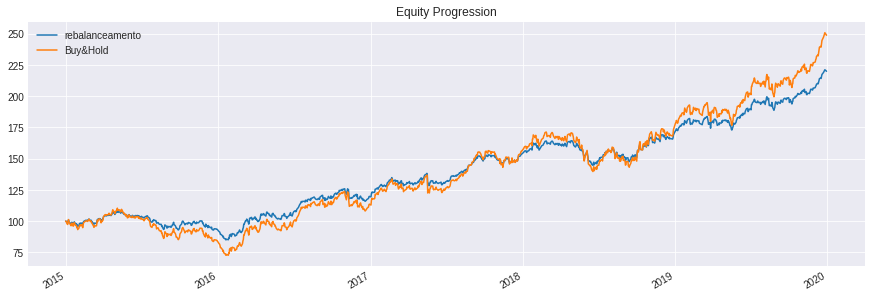

In [17]:
resultados.plot();

## Operações

In [18]:
resultados.get_transactions()

price  quantity
Date       Security                        
2015-01-02 BOVA11.SA    47.259998    7053.0
           SMAL11.SA    52.020000    6407.0
           renda_fixa    1.000000  333333.0
2015-01-30 BOVA11.SA    45.610001     -52.0
           SMAL11.SA    46.790001     417.0
...                           ...       ...
2019-10-31 SMAL11.SA   115.570000     -43.0
           renda_fixa    1.588157    5140.0
2019-11-29 BOVA11.SA   104.349998      67.0
           SMAL11.SA   121.199997    -153.0
           renda_fixa    1.594198    7323.0

[179 rows x 2 columns]

## Pesos

In [19]:
resultados.get_security_weights()

BOVA11.SA  SMAL11.SA  renda_fixa
2015-01-01   0.000000   0.000000    0.000000
2015-01-02   0.333325   0.333292    0.333333
2015-01-05   0.331926   0.329059    0.338964
2015-01-06   0.334314   0.325991    0.339645
2015-01-07   0.338950   0.327728    0.333272
...               ...        ...         ...
2019-12-20   0.335707   0.347352    0.316922
2019-12-23   0.336148   0.348800    0.315034
2019-12-26   0.336444   0.351306    0.312232
2019-12-27   0.335037   0.352192    0.312753
2019-12-30   0.333585   0.352313    0.314083

[1236 rows x 3 columns]

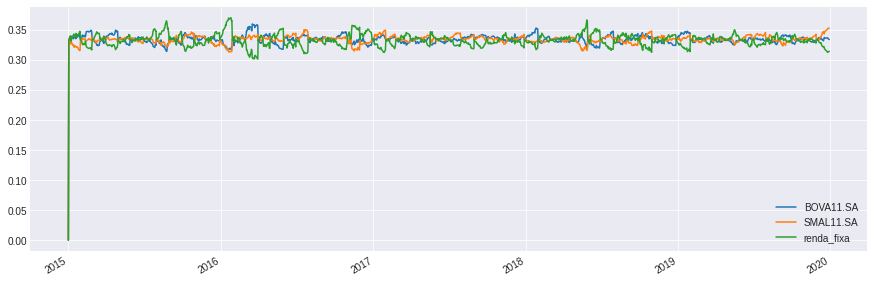

In [20]:
resultados.plot_security_weights()